In [2]:
!pip install pandas numpy
!pip install matplotlib
!pip install xgboost
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [3]:
!pip install xgboost

In [4]:
import os

In [5]:
import pandas as pd
import numpy as np

In [6]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint


# New section

In [9]:
store_sales=pd.read_csv('/content/train.csv')

In [10]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [11]:
#checking null values and column info
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   store   57967 non-null  int64 
 2   item    57967 non-null  int64 
 3   sales   57967 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


In [12]:
#sales prediction not require store id and item id (dropping columns-store,item)
store_sales = store_sales.drop(['store','item'],axis=1)

In [13]:
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [14]:
#converting date from object datatype to dateTime datatype
store_sales['date']=pd.to_datetime(store_sales['date'])

In [16]:
#converting to date into month period to predict for each month
store_sales['date']=store_sales['date'].dt.to_period('M')
monthly_sales=store_sales.groupby('date').sum().reset_index()

AttributeError: 'PeriodProperties' object has no attribute 'to_period'

In [17]:
#convert the resulting date column to timestamp datatype
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [18]:
monthly_sales.head()

,date,sales
0,2013-01-01,21332
1,2013-02-01,21556
2,2013-03-01,28791
3,2013-04-01,31696
4,2013-05-01,35647


Text(0, 0.5, 'Sales')

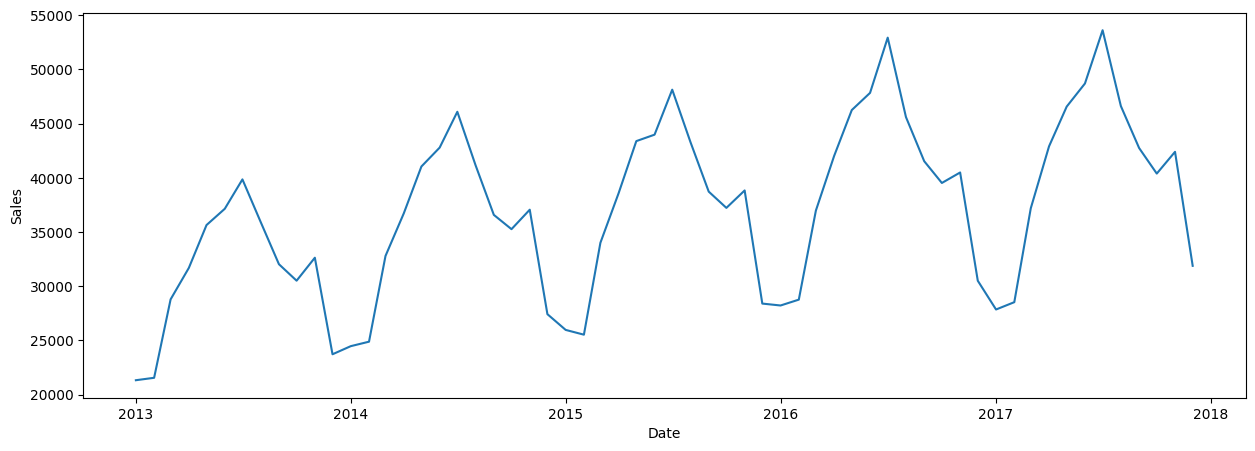

In [22]:
#visualization
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')

In [24]:
#trend showing increasing pattern in sales over a time
#making data stationary by call the diff on sales column (get diff over month)

monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna() #cleaning
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,21556,224.0
2,2013-03-01,28791,7235.0
3,2013-04-01,31696,2905.0
4,2013-05-01,35647,3951.0
5,2013-06-01,37147,1500.0


Text(0, 0.5, 'Sales')

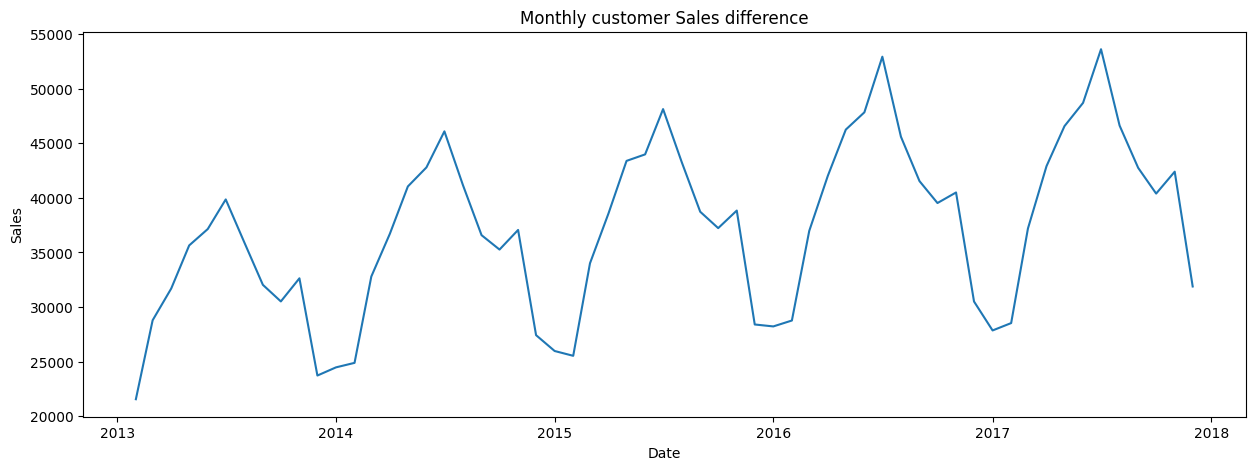

In [26]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('Date')
plt.title('Monthly customer Sales difference')
plt.ylabel('Sales')

In [28]:
#predict sales in next month
#supervised learning on 12 past month
#drop sale & date (only require stationary diff only)
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

In [30]:
#preparing data (filter past 12 month data)
#get sales diff for each store as per month
for i in range(1,13):
  col_name='month_'+str(i)
  supervised_data[col_name]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0,224.0
1,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0
2,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0
3,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0
4,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0


In [33]:
#split dataset in train & test data
train_data=supervised_data[:-12]  #previous 12 month
test_data=supervised_data[-12:]   #coming 12 month
print("train data shape",train_data.shape)
print("test data shape",test_data.shape)

train data shape (35, 13)
test data shape (12, 13)


In [34]:
#feature scaling to restrict value to -1 & 1 (minmax scaling)
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [35]:
x_train,y_train =train_data[:,1:],train_data[:,0:1]
x_test,y_test =test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("X_train shape ",x_train.shape)
print("y_train shape ",y_train.shape)
print("X_test shape ",x_test.shape)
print("X_test shape ",x_test.shape)
#above is data preprocessing to make prediction dframe to merge predicted sale price of all trained algo

X_train shape  (35, 12)
y_train shape  (35,)
X_test shape  (12, 12)
X_test shape  (12, 12)


In [36]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [37]:
actual_sales=monthly_sales['sales'][-13:].to_list()
actual_sales

[30509,
 27857,
 28532,
 37194,
 42907,
 46574,
 48706,
 53621,
 46627,
 42754,
 40395,
 42403,
 31884]

Forecasting
1.forecasting with linear regression

In [38]:
#create regression model and predict
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre=lr_model.predict(x_test)

In [40]:
#min max scale need transform predicted values to their original scale
lr_pre=lr_pre.reshape(-1,1)
#matrix contains input feature of test data and also predicted output
lr_pre_test_set=np.concatenate((lr_pre,x_test),axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set) #inverse transform - to original scale

In [48]:
result_list=[]
for index in range (0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+actual_sales[index])
lr_pre_series =pd.Series(result_list,name="Linear Prediction")
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [56]:
lr_mse=np.sqrt(mean_squared_error(predict_df['Linear Prediction_x'],monthly_sales['sales'][-12:]))
lr_mae=mean_absolute_error(predict_df['Linear Prediction_x'],monthly_sales['sales'][-12:])
lr_r2=r2_score=(predict_df['Linear Prediction_x'],monthly_sales['sales'][-12:])

Text(0.5, 1.0, 'customer sales forecast ')

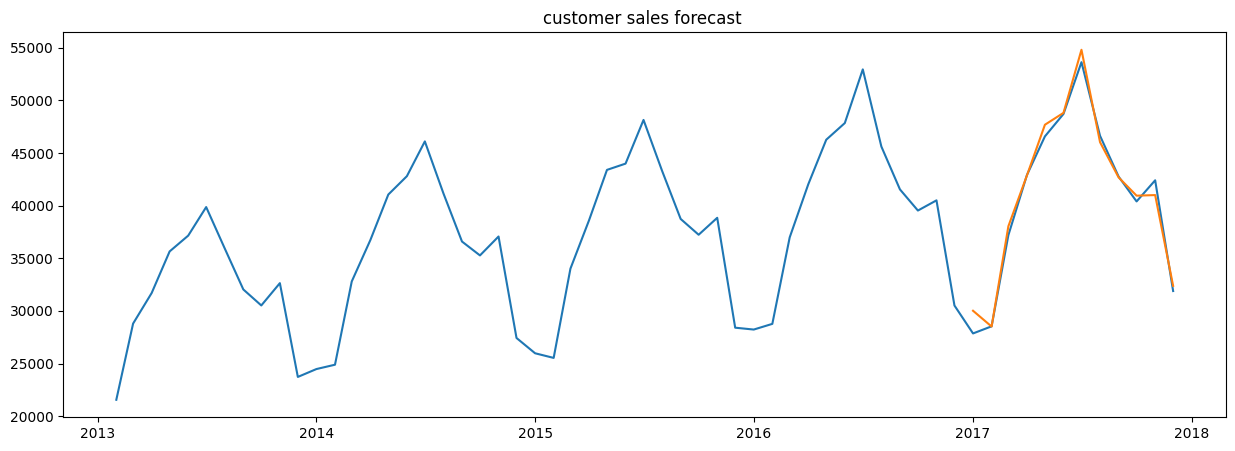

In [58]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'],predict_df['Linear Prediction_x'])
plt.title("customer sales forecast ")